# NERCOME estimator to obtain covariance matrix

In [1]:
import numpy as np
import itertools as it
import math
import matplotlib.pyplot as plt
%matplotlib inline

Generate data

In [2]:
# Parameters
Nd = 4 # Number of random variables
Ns = 6 # Number of data realizations

In [3]:
# Generate random matrix of size Nd x Ns
A = np.random.normal(0, 1, size=(Nd//2, Ns))
B = np.random.normal(0, np.sqrt(5), size=(Nd-Nd//2, Ns))
X = np.vstack((A, B))
# The resulting matrix X = (x_1, x_2, ..., x_Ns) consists of n column vectors,
# of which each x_i has length p, the upper half has variance 1 and the lower half has variance 5

#print(X)

The standard sample covariance estimator is given by
$ \hat{S} = \frac{1}{N_s-1} X X^T$

In [4]:
S = 1/(Ns-1)*np.matmul(X, X.T)
print(S)

[[ 1.02533263  0.84813413  0.53054176 -1.03306547]
 [ 0.84813413  2.46766791  0.54350367 -0.35839083]
 [ 0.53054176  0.54350367  7.18798394  0.8061667 ]
 [-1.03306547 -0.35839083  0.8061667   1.8272967 ]]


Then the covariance matrix $ \Sigma = \mathbb{E}(\hat{S}) $

In [5]:
S_sum = np.zeros((Nd, Nd))
n = 10
for _ in range(n):
    A = np.random.normal(0, 1, size=(Nd//2, Ns))
    B = np.random.normal(0, np.sqrt(5), size=(Nd-Nd//2, Ns))
    X = np.vstack((A, B))
    S_sum += 1/(Ns-1)*np.matmul(X, X.T)
CovM = S_sum / n
print(CovM)

[[ 1.17387621 -0.03446626 -0.01708831 -0.18182203]
 [-0.03446626  0.89137685 -0.38574929  0.23322095]
 [-0.01708831 -0.38574929  6.54864851 -1.87986705]
 [-0.18182203  0.23322095 -1.87986705  6.20876125]]


The NERCOME procedure divides the dataset into two subsamples, $X = (X_1, X_2)$, where $X_1$ is an $N_d \times s$ matrix and $X_2$ is an $N_d \times (N_s - s)$ matrix.

In [6]:
def Q_func(s, X):
    Nd, Ns = X.shape
    assert s >= 2 and s <= (Ns-2) and math.floor(s) == s
    col_combos = list(it.combinations(range(Ns), s)) # Tuples of possible combinations of s out of Ns column indices

    Z_sum = np.zeros((Nd, Nd))
    S2_sum = np.zeros((Nd, Nd))

    for col_combo in col_combos:
        X1 = X[:, col_combo]
        X2 = X[:, np.delete(range(Ns), col_combo)]
        
        S1 = 1/(s-1)*np.matmul(X1, X1.T)
        S2 = 1/(Ns-s-1)*np.matmul(X2, X2.T)
        S2_sum += S2
        
        # Diagonalize S_i = U_i * D_i * U_i^T
        evals1, U1 = np.linalg.eigh(S1)
        D1 = np.diag(evals1)
        #evals2, U2 = np.linalg.eig(S2)
        #D2 = np.diag(evals2)
        
        # Verify that the matrix diagonalization is correct (up to absolute error of 1e^-10)
        S1_trial = np.matmul(np.matmul(U1, D1), U1.T)
        #S2_trial = np.matmul(np.matmul(U2, D2), U2.T)
        assert np.allclose(S1, S1_trial, 0, 1e-10)
        #assert np.allclose(S2, S2_trial, 0, 1e-10)
        
        # Compute estimator Z = U_1 * diag(U_1^T * S_2 * U_1) * U_1^T
        Z = np.matmul(np.matmul(U1, np.diag(np.diag(np.matmul(np.matmul(U1.T, S2), U1)))), U1.T)
        Z_sum += Z
    
    Z_avg = Z_sum / len(col_combos)
    S2_avg = S2_sum / len(col_combos)
    M = Z_avg - S2_avg
    Q_val = np.trace(np.matmul(M, M.T)) # Frobenius matrix norm
    
    return Q_val, Z_avg

In [7]:
# Parameters
Nd = 30 # Number of random variables
Ns = 20 # Number of data realizations

varA = 5.0 # Variance of first half of random variables
varB = 1.0 # Variance of second half of random variables

# Generate random matrix of size Nd x Ns
A = np.random.normal(0, np.sqrt(varA), size=(Nd//2, Ns))
B = np.random.normal(0, np.sqrt(varB), size=(Nd-Nd//2, Ns))
X = np.vstack((A, B))

Text(0, 0.5, 'Q(s)')

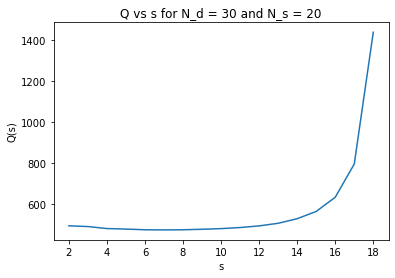

In [8]:
s = np.arange(Ns-3)+2
Q = []
for i in s:
    Q.append(Q_func(i, X)[0])

plt.plot(s, Q)
plt.title(f"Q vs s for N_d = {Nd} and N_s = {Ns}")
plt.xlabel("s")
plt.ylabel("Q(s)")

In [9]:
s_min = s[np.array(Q).argmin()]
print(s_min)

7


In [10]:
Z = Q_func(s_min, X)[1]
S = 1/(Ns-1)*np.matmul(X, X.T)

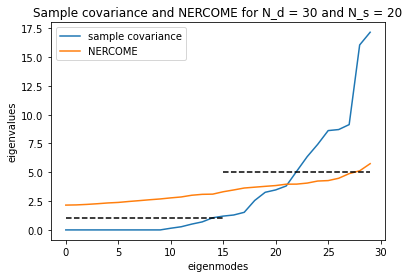

In [12]:
sample_cov_evals = np.linalg.eigvalsh(S)
nercome_evals = np.linalg.eigvalsh(Z)

plt.plot(sample_cov_evals, label="sample covariance")
plt.plot(nercome_evals, label="NERCOME")
plt.plot(np.arange(Nd//2+1), np.full(Nd//2+1, varB), "k--")
plt.plot(np.arange(Nd-Nd//2)+Nd//2, np.full(Nd-Nd//2, varA), "k--")
plt.ylabel("eigenvalues")
plt.xlabel("eigenmodes")
plt.title(f"Sample covariance and NERCOME for N_d = {Nd} and N_s = {Ns}")
plt.legend()